In [ ]:
TRAIN_IMAGE_PATH = '/dataset/train/images'
TRAIN_ANNOTS_PATH = '/dataset/train/annots'
TEST_IMAGE_PATH = '/dataset/valid/images'
TEST_ANNOTS_PATH = '/dataset/valid/annots'

In [ ]:
import numpy as np
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import cv2 as cv

import torch
from torch import nn
import xml.etree.ElementTree as ET
import torchvision
from PIL import Image, ImageDraw
from torch.utils.data import Dataset, DataLoader
import collections
import torch.nn.functional as F
from scipy.optimize import linear_sum_assignment

In [ ]:
def conv_batch(in_num, out_num, kernel_size=3, padding=1, stride=1):
    return nn.Sequential(
        nn.Conv2d(in_num, out_num, kernel_size=kernel_size, stride=stride, padding=padding, bias=False),
        nn.BatchNorm2d(out_num),
        nn.LeakyReLU())

In [ ]:
class DarkResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(DarkResidualBlock, self).__init__()

        reduced_channels = int(in_channels/2)

        self.layer1 = conv_batch(in_channels, reduced_channels, kernel_size=1, padding=0)
        self.layer2 = conv_batch(reduced_channels, in_channels)

    def forward(self, x):
        residual = x

        out = self.layer1(x)
        out = self.layer2(out)
        out += residual
        return out

In [ ]:
class DarkNet(nn.Module):
    def __init__(self, block):
        super(DarkNet, self).__init__()

        self.conv1 = conv_batch(3, 32)

        self.conv2 = conv_batch(32, 64, stride=2)
        self.residual_block1 = self.make_layer(block, in_channels=64, num_blocks=1)

        self.conv3 = conv_batch(64, 128, stride=2)
        self.residual_block2 = self.make_layer(block, in_channels=128, num_blocks=2)

        self.conv4 = conv_batch(128, 256, stride=2)
        self.residual_block3 = self.make_layer(block, in_channels=256, num_blocks=8)

        self.conv5 = conv_batch(256, 512, stride=2)
        self.residual_block4 = self.make_layer(block, in_channels=512, num_blocks=8)

        self.conv6 = conv_batch(512, 1024, stride=2)
        self.residual_block5 = self.make_layer(block, in_channels=1024, num_blocks=4)

        self.max_pool = nn.MaxPool2d(kernel_size = 4, stride = 2)
        self.conv7 = conv_batch(1024, 5, stride=2)
        self.residual_block6 = self.make_layer(block, in_channels=5, num_blocks=4)

        #self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        #self.fc = nn.Linear(2048, self.num_classes)
    
    def forward(self, x):
        out = self.conv1(x)

        out = self.conv2(out)
        out = self.residual_block1(out)

        out = self.conv3(out)
        out = self.residual_block2(out)

        out = self.conv4(out)
        out = self.residual_block3(out)

        out = self.conv5(out)
        out = self.residual_block4(out)

        out = self.conv6(out)
        out = self.residual_block5(out)

        out = self.max_pool(out)
        out = self.conv7(out)
        out = self.residual_block6(out)

        '''
        for i in range(out.shape[0]):
            c = torch.sigmoid(out[i][0])
            x = out[i][1] * (1280 / 10)
            y = out[i][2] * (720 / 5) 
            h = out[i][3] * (720 / 5)
            w = out[i][4] * (1280 / 10)
            
            out[i][0] = c
            out[i][1] = x - w / 2
            out[i][2] = y - h / 2
            out[i][3] = x + w / 2
            out[i][4] = y + h / 2'''

        grid_width = out.shape[3] / 10
        grid_height = out.shape[2] / 5
        for row in range(out.shape[2]): #5
            dy = (row * grid_width) + (grid_width / 2)
            for col in range(out.shape[3]): #10
                dx = (col * grid_height) + (grid_height / 2)
                
                c = torch.sigmoid(out[0][0][row][col])
                x = out[0][1][row][col] * grid_width + dx
                y = out[0][2][row][col] * grid_height + dy
                h = out[0][3][row][col] * grid_height
                w = out[0][4][row][col] * grid_width

                out[0][0][row][col] = c
                out[0][1][row][col] = x - w / 2
                out[0][2][row][col] = y - h / 2
                out[0][3][row][col] = x + w / 2
                out[0][4][row][col] = y + h / 2

        out = out[0].permute(1, 2, 0)
        out = torch.reshape(out, (50, 5))

        return out

    def make_layer(self, block, in_channels, num_blocks):
        layers = []
        for i in range(0, num_blocks):
            layers.append(block(in_channels))
        return nn.Sequential(*layers)
def darknet():
    return DarkNet(DarkResidualBlock)

In [ ]:
def getPaths(images_path = TRAIN_IMAGE_PATH, annots_path = TRAIN_ANNOTS_PATH):
    file_names = [i[:-4] for i in os.listdir(images_path)]
    images = [os.path.join(images_path, x + ".jpg") for x in file_names]
    targets = [os.path.join(annots_path, x + ".xml") for x in file_names]
    assert len(images) == len(targets)
    return images, targets

In [ ]:
def parse_voc_xml(node: ET.Element):
        voc_dict = {}
        children = list(node)
        if children:
            def_dic = collections.defaultdict(list)
            for dc in map(parse_voc_xml, children):
                for ind, v in dc.items():
                    def_dic[ind].append(v)
            if node.tag == "annotation":
                def_dic["object"] = [def_dic["object"]]
            voc_dict = {node.tag: {ind: v[0] if len(v) == 1 else v for ind, v in def_dic.items()}}
        if node.text:
            text = node.text.strip()
            if not children:
                voc_dict[node.tag] = text
        return voc_dict

In [ ]:
def getItem(index, reverse = True):
    img = np.array(Image.open(images[index]).convert("RGB"))
    target = parse_voc_xml(ET.parse(targets[index]).getroot())

    arr = None
    for i in target['annotation']['object']:
        xmin = float(i['bndbox']['xmin'])
        ymin = float(i['bndbox']['ymin'])
        xmax = float(i['bndbox']['xmax'])
        ymax = float(i['bndbox']['ymax'])
        if arr == None:
            arr = torch.tensor([[xmin, ymin, xmax, ymax]])
        else:
            temp = torch.tensor([[xmin, ymin, xmax, ymax]])
            arr = torch.cat((arr, temp), 0)

    if reverse == False:
        return torch.from_numpy(img) / 255, arr
    return torch.from_numpy(img).permute(2, 0, 1) / 255, arr

In [ ]:
images, targets = getPaths()

In [ ]:
images

['/Users/gafur/Desktop/license-plate-dataset-master/dataset/train/images/nightride_type3_001.mp4#t=16.jpg',
 '/Users/gafur/Desktop/license-plate-dataset-master/dataset/train/images/dayride_type1_001.mp4#t=1472.jpg',
 '/Users/gafur/Desktop/license-plate-dataset-master/dataset/train/images/dayride_type1_001.mp4#t=1466.jpg',
 '/Users/gafur/Desktop/license-plate-dataset-master/dataset/train/images/dayride_type1_001.mp4#t=1300.jpg',
 '/Users/gafur/Desktop/license-plate-dataset-master/dataset/train/images/dayride_type1_001.mp4#t=431.jpg',
 '/Users/gafur/Desktop/license-plate-dataset-master/dataset/train/images/dayride_type1_001.mp4#t=343.jpg',
 '/Users/gafur/Desktop/license-plate-dataset-master/dataset/train/images/dayride_type1_001.mp4#t=1116.jpg',
 '/Users/gafur/Desktop/license-plate-dataset-master/dataset/train/images/dayride_type1_001.mp4#t=586.jpg',
 '/Users/gafur/Desktop/license-plate-dataset-master/dataset/train/images/dayride_type1_001.mp4#t=1089.jpg',
 '/Users/gafur/Desktop/license-

In [ ]:
data = []
for i in range(len(images)):
    data.append(getItem(i))

In [ ]:
train_loader = DataLoader(data, batch_size=1, shuffle=True)

In [ ]:
for batch in train_loader:
    print(batch[1].shape)

torch.Size([1, 1, 4])
torch.Size([1, 1, 4])
torch.Size([1, 1, 4])
torch.Size([1, 1, 4])
torch.Size([1, 1, 4])
torch.Size([1, 1, 4])
torch.Size([1, 1, 4])
torch.Size([1, 1, 4])
torch.Size([1, 1, 4])
torch.Size([1, 1, 4])
torch.Size([1, 2, 4])
torch.Size([1, 2, 4])
torch.Size([1, 1, 4])
torch.Size([1, 1, 4])
torch.Size([1, 1, 4])
torch.Size([1, 1, 4])
torch.Size([1, 1, 4])
torch.Size([1, 1, 4])
torch.Size([1, 1, 4])
torch.Size([1, 1, 4])
torch.Size([1, 2, 4])
torch.Size([1, 1, 4])
torch.Size([1, 2, 4])
torch.Size([1, 1, 4])
torch.Size([1, 1, 4])
torch.Size([1, 1, 4])
torch.Size([1, 1, 4])
torch.Size([1, 1, 4])
torch.Size([1, 2, 4])
torch.Size([1, 2, 4])
torch.Size([1, 1, 4])
torch.Size([1, 1, 4])
torch.Size([1, 1, 4])
torch.Size([1, 1, 4])
torch.Size([1, 1, 4])
torch.Size([1, 3, 4])
torch.Size([1, 1, 4])
torch.Size([1, 1, 4])
torch.Size([1, 2, 4])
torch.Size([1, 2, 4])
torch.Size([1, 2, 4])
torch.Size([1, 1, 4])
torch.Size([1, 1, 4])
torch.Size([1, 1, 4])
torch.Size([1, 1, 4])
torch.Size

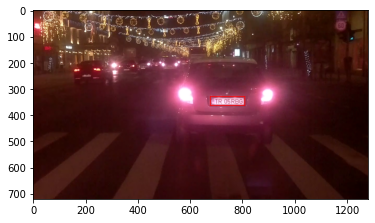

In [ ]:
index = 0
image, target = getItem(index, False)
c = Image.fromarray(np.uint8(image * 255))
b = ImageDraw.Draw(c)
for i in target:
    xmin, ymin, xmax, ymax = i
    b.rectangle(((xmin, ymin), (xmax,ymax)), outline='red', width = 3)
plt.imshow(c)
#plt.imshow(getItem(0)[0])

In [ ]:
for batch in train_loader:
    print(batch[1].shape)

torch.Size([1, 1, 4])
torch.Size([1, 1, 4])
torch.Size([1, 1, 4])
torch.Size([1, 2, 4])
torch.Size([1, 1, 4])
torch.Size([1, 1, 4])
torch.Size([1, 1, 4])
torch.Size([1, 1, 4])
torch.Size([1, 1, 4])
torch.Size([1, 1, 4])
torch.Size([1, 1, 4])
torch.Size([1, 1, 4])
torch.Size([1, 2, 4])
torch.Size([1, 1, 4])
torch.Size([1, 1, 4])
torch.Size([1, 1, 4])
torch.Size([1, 2, 4])
torch.Size([1, 1, 4])
torch.Size([1, 1, 4])
torch.Size([1, 1, 4])
torch.Size([1, 1, 4])
torch.Size([1, 1, 4])
torch.Size([1, 1, 4])
torch.Size([1, 1, 4])
torch.Size([1, 1, 4])
torch.Size([1, 1, 4])
torch.Size([1, 1, 4])
torch.Size([1, 1, 4])
torch.Size([1, 2, 4])
torch.Size([1, 1, 4])
torch.Size([1, 1, 4])
torch.Size([1, 2, 4])
torch.Size([1, 2, 4])
torch.Size([1, 2, 4])
torch.Size([1, 1, 4])
torch.Size([1, 1, 4])
torch.Size([1, 1, 4])
torch.Size([1, 1, 4])
torch.Size([1, 1, 4])
torch.Size([1, 1, 4])
torch.Size([1, 1, 4])
torch.Size([1, 2, 4])
torch.Size([1, 1, 4])
torch.Size([1, 1, 4])
torch.Size([1, 1, 4])
torch.Size

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(F.log_softmax(outputs, dim=1), dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))
  
def predicts(outputs):
    _, preds = torch.max(F.log_softmax(outputs, dim=1), dim=1)
    return preds
  
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
def confidence_loss(x):
    return -torch.log(x + 0.0000000001)

In [ ]:
def location_loss(a, b):
    loss = nn.MSELoss()
    return loss(a, b)

In [ ]:
def negative_loss(a):
    return -torch.log(1 - a + 0.0000000001)

In [ ]:
def isEqual(col, col_ind):
    for i in range(len(col_ind)):
        if col_ind[i] == col:
            return True
    return False

In [ ]:
def customBackward(output, target, W_conf, W_pos): #pred, actual
    target = target[0]
    losses = torch.zeros(len(target), len(output))
    for row in range(len(target)):
        for col in range(len(output)):
            losses[row][col] = confidence_loss(output[col][0]) + location_loss(target[row][:], output[col][1:])
    row_ind, col_ind = linear_sum_assignment(losses.detach().numpy())

    positive = torch.reshape(output[col_ind[0]], (1, len(output[col_ind[0]])))
    for i in range(len(col_ind[1:])):
        positive = torch.cat((positive, torch.reshape(output[col_ind[i+1]], (1, len(output[col_ind[i+1]])))), 0)

    negative = output
    for i in np.sort(col_ind)[::-1]:
        negative = torch.cat([negative[0:i], negative[i+1:]])

    positive_losses = torch.zeros(len(target), len(positive))
    for row in range(len(target)):
        for col in range(len(positive)):
            positive_losses[row][col] = W_conf * confidence_loss(positive[col][0]) + (1 - W_conf) * location_loss(target[row][:], positive[col][1:])
    positive_losses = torch.mean(positive_losses)

    negative_losses = torch.zeros(len(negative))
    for row in range(len(negative)):
        negative_losses[row] = negative_loss(negative[row][0])
    negative_losses = torch.mean(negative_losses)
    
    total_loss = W_pos * positive_losses + (1 - W_pos) * negative_losses
    return total_loss

In [ ]:
def train(model, batch, optimizer):
    model.train()
    optimizer.zero_grad()
    inputs, labels = batch
    #inputs = inputs.cuda()
    #labels = labels.cuda()
    outputs = model(inputs)
    #print('outputs =', outputs, '     ', torch.max(F.log_softmax(outputs, dim=1), dim=1)[1], '     ', labels)
    #l = criterion(outputs, labels)
    l = customBackward(outputs, labels, 0.35, 0.3)
    #print('criterion =', l)
    l.backward()
    #print('criterion =', l)
    optimizer.step()
    #print('criterion =', l.item())
    return l


def evaluate(model, batch, optimizer):
    model.eval()
    inputs, labels = batch
    #inputs = inputs.cuda()
    #labels = labels.cuda()
    outputs = model(inputs)
    #a = accuracy(outputs, labels)
    a = None
    #l = criterion(outputs, labels)
    l =customBackward(outputs,labels, 0.35, 0.3)
    return a, l

In [ ]:
model = darknet()
model.load_state_dict(torch.load('/Users/gafur/Desktop/model.pt'))
model.eval()

DarkNet(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (residual_block1): Sequential(
    (0): DarkResidualBlock(
      (layer1): Sequential(
        (0): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.01)
      )
      (layer2): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runni

In [ ]:
LEARNING_RATE = 0.05
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
epoches = 50

train_loader = DataLoader(data, batch_size=1, shuffle=True)
val_loader = DataLoader(data, batch_size=1)

In [ ]:
for epoch in range(epoches):
    print('Epoch:', epoch + 1)
    c = 0
    cost = 0
    for batch in train_loader:
        l = train(model, batch, optimizer)
        c += len(batch[0])
        print("[%d/%d] Loss: %.2f" % (c, len(data), l.item()))
        cost += l.item()
    print('Cost:', cost / 427)
    '''for batch in train_loader:
        a, l = evaluate(model, batch, optimizer)
        print("Train Loss: %.2f, Train Accuracy: %.2f" % (l.item(), a.item()))
        break'''
    torch.save(model.state_dict(), '/Users/gafur/Desktop/model.pt')

Epoch: 1
[1/427] Loss: 322.67
[2/427] Loss: 7341.69
[3/427] Loss: 250.01
[4/427] Loss: 109.27
[5/427] Loss: 367.42
[6/427] Loss: 542.58
[7/427] Loss: 916.75
[8/427] Loss: 250.10
[9/427] Loss: 17841.03
[10/427] Loss: 58.03
[11/427] Loss: 923.10
[12/427] Loss: 230.91
[13/427] Loss: 2307.50
[14/427] Loss: 129.72
[15/427] Loss: 715.31
[16/427] Loss: 947.31
[17/427] Loss: 1335.26
[18/427] Loss: 1902.33
[19/427] Loss: 7205.98
[20/427] Loss: 682.22
[21/427] Loss: 11103.16
[22/427] Loss: 12.32
[23/427] Loss: 169.36
[24/427] Loss: 465.98
[25/427] Loss: 16458.31
[26/427] Loss: 7801.18
[27/427] Loss: 3530.39
[28/427] Loss: 6342.17
[29/427] Loss: 22.74
[30/427] Loss: 539.00
[31/427] Loss: 16088.94
[32/427] Loss: 533.31
[33/427] Loss: 519.79
[34/427] Loss: 3146.04
[35/427] Loss: 464.40
[36/427] Loss: 138.29
[37/427] Loss: 2533.43
[38/427] Loss: 103.54
[39/427] Loss: 413.48
[40/427] Loss: 686.98
[41/427] Loss: 2785.42
[42/427] Loss: 234.70
[43/427] Loss: 299.96
[44/427] Loss: 128.60
[45/427] Loss: 3

KeyboardInterrupt: 

In [ ]:
def eval(after):
    image = torch.reshape(after[0].permute(2, 3, 1, 0), (720, 1280, 3))
    out = None
    for i in after[1]:
        if i[0] >= 0.5:
            out = i
            break
    c = Image.fromarray(np.uint8(image * 255))
    b = ImageDraw.Draw(c)

    conf, xmin, ymin, xmax, ymax = i[0].item(), i[1].item(), i[2].item(), i[3].item(), i[4].item()

    b.rectangle(((xmin, ymin), (xmax,ymax)), outline='red', width = 3)
    plt.imshow(c)
    plt.show()

In [ ]:
eval(after)